## Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzipping the datafolder

In [3]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/smai_a4/fashion_mnist.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

!rm -rf /content/__MACOSX

## Solving fragmentation issue for memory

In [4]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

## Imports

In [5]:
import struct
import torch
import torch.nn as nn
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Dataloader and Autoencoder Class

In [34]:
class MultiMNISTDataset:
    def __init__(self, data, labels, batch_size=32, shuffle=True, task="classification"):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))  # Track the indexes for shuffling
        self.current_index = 0
        self.task = task

        if self.shuffle:
            self._shuffle_data()

    def _shuffle_data(self):
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __iter__(self):
        self.current_index = 0
        if self.shuffle:
            self._shuffle_data()
        return self

    def __next__(self):
        if self.current_index >= len(self.data):
            raise StopIteration

        # Compute the indices of the current batch
        start_idx = self.current_index
        end_idx = min(start_idx + self.batch_size, len(self.data))

        # Fetch the batch data and labels
        batch_indexes = self.indexes[start_idx:end_idx]
        batch_data = self.data[batch_indexes]
        batch_labels = self.labels[batch_indexes]

        # Update the current index
        self.current_index = end_idx

        # Convert NumPy arrays to PyTorch tensors
        batch_data_tensor = torch.from_numpy(batch_data).float().unsqueeze(1)
        if self.task == "classification":
            batch_labels_tensor = torch.from_numpy(batch_labels).long()
        elif self.task == "regression":
            batch_labels_tensor = torch.from_numpy(batch_labels).float()

        return batch_data_tensor, batch_labels_tensor

class CNN_Autoencoder(nn.Module):
    def __init__(self, model_num: int, act_func: str, lr: float, dropout: float, optimiser: str):
        super(CNN_Autoencoder, self).__init__()
        self.loss = nn.MSELoss()

        if act_func == 'relu':
            self.activation = torch.relu
        elif act_func == 'sigmoid':
            self.activation = torch.sigmoid
        elif act_func == 'tanh':
            self.activation = torch.tanh
        else:
            raise ValueError('Activation function not supported.')

        self.lr = lr
        self.dropout = dropout
        self.op = optimiser
        self.model_num = model_num

        if self.model_num==1 or self.model_num==2 or self.model_num==3:
            # Encoding layers
            self.conv1 = nn.Conv2d(1, 16, 3)                            # 1x28x28 -> 16x26x26
            self.maxpool1 = nn.MaxPool2d(2, 2, return_indices=True)     # 16x26x26 -> 16x13x13
            self.conv2 = nn.Conv2d(16, 32, 3)                           # 16x13x13 -> 32x11x11
            self.maxpool2 = nn.MaxPool2d(2, 2, return_indices=True)     # 32x11x11 -> 32x5x5
            self.conv3 = nn.Conv2d(32, 64, 5)                           # 32x5x5 -> 64x1x1

            # Decoder layers
            self.inv_conv3 = nn.ConvTranspose2d(64, 32, 5)              # 64x1x1 -> 32x5x5
            self.maxunpool2 = nn.MaxUnpool2d(2, 2)                      # 32x5x5 -> 32x11x11
            self.inv_conv2 = nn.ConvTranspose2d(32, 16, 3)              # 32x11x11 -> 16x13x13
            self.maxunpool1 = nn.MaxUnpool2d(2, 2)                      # 16x13x13 -> 16x26x26
            self.inv_conv1 = nn.ConvTranspose2d(16, 1, 3)               # 16x26x26 -> 1x28x28
            self.normalise = nn.Sigmoid()                               # Normalise the output image in range [0, 1]

        elif self.model_num == 2:
            # Encoding layers
            self.conv1 = nn.Conv2d(1, 32, 5)                            # 1x28x28 -> 32x24x24
            self.maxpool1 = nn.MaxPool2d(2, 2, return_indices=True)     # 32x24x24 -> 32x12x12
            self.conv2 = nn.Conv2d(32, 64, 5)                           # 64x12x12 -> 64x8x8
            self.maxpool2 = nn.MaxPool2d(2, 2, return_indices=True)     # 64x8x8 -> 64x4x4
            self.conv3 = nn.Conv2d(64, 128, 4)                          # 64x4x4 -> 128x1x1

            # Decoder layers
            self.inv_conv3 = nn.ConvTranspose2d(128, 64, 4)             # 128x1x1 -> 64x4x4
            self.maxunpool2 = nn.MaxUnpool2d(2, 2)                      # 64x4x4 -> 64x8x8
            self.inv_conv2 = nn.ConvTranspose2d(64, 32, 5)              # 64x8x8 -> 32x12x12
            self.maxunpool1 = nn.MaxUnpool2d(2, 2)                      # 32x12x12 -> 32x24x24
            self.inv_conv1 = nn.ConvTranspose2d(32, 1, 5)               # 32x24x24 -> 1x28x28
            self.normalise = nn.Sigmoid()                               # Normalise the output image in range [0, 1]

        elif self.model_num == 3:
            # Encoding layers
            self.conv1 = nn.Conv2d(1, 64, 5)                            # 1x28x28 -> 64x24x24
            self.maxpool1 = nn.MaxPool2d(2, 2, return_indices=True)     # 64x24x24 -> 64x12x12
            self.conv2 = nn.Conv2d(64, 128, 5)                          # 64x12x12 -> 128x8x8
            self.maxpool2 = nn.MaxPool2d(2, 2, return_indices=True)     # 128x8x8 -> 128x4x4
            self.conv3 = nn.Conv2d(128, 256, 4)                         # 128x4x4 -> 256x1x1

            # Decoder layers
            self.inv_conv3 = nn.ConvTranspose2d(256, 128, 4)            # 256x1x1 -> 128x4x4
            self.maxunpool2 = nn.MaxUnpool2d(2, 2)                      # 128x4x4 -> 128x8x8
            self.inv_conv2 = nn.ConvTranspose2d(128, 64, 5)             # 128x8x8 -> 64x12x12
            self.maxunpool1 = nn.MaxUnpool2d(2, 2)                      # 64x12x12 -> 64x24x24
            self.inv_conv1 = nn.ConvTranspose2d(64, 1, 5)               # 64x24x24 -> 1x28x28
            self.normalise = nn.Sigmoid()                               # Normalise the output image in range [0, 1]

        # Keeping the latent space dimensions same and varying the depth of the model
        elif self.model_num == 4:
            # Encoding layers
            self.conv1 = nn.Conv2d(1, 256, 5)                           # 1x28x28 -> 64x24x24
            self.maxpool1 = nn.MaxPool2d(2, 2, return_indices=True)     # 64x24x24 -> 64x12x12
            self.conv2 = nn.Conv2d(256, 128, 12)                        # 64x12x12 -> 128x1x1

            # Decoder layers
            self.inv_conv2 = nn.ConvTranspose2d(128, 256, 12)           # 128x1x1 -> 64x12x12
            self.maxunpool1 = nn.MaxUnpool2d(2, 2)                      # 64x12x12 -> 64x24x24
            self.inv_conv1 = nn.ConvTranspose2d(256, 1, 5)              # 64x24x24 -> 1x28x28
            self.normalise = nn.Sigmoid()                               # Normalise the output image in range [0, 1]

        elif self.model_num == 5:
            # Encoding layers
            self.conv1 = nn.Conv2d(1, 512, 5)                           # 1x28x28 -> 512x24x24
            self.maxpool1 = nn.MaxPool2d(2, 2, return_indices=True)     # 512x24x24 -> 512x12x12
            self.conv2 = nn.Conv2d(512, 256, 5)                         # 512x12x12 -> 256x8x8
            self.maxpool2 = nn.MaxPool2d(2, 2, return_indices=True)    # 256x8x8 -> 256x4x4
            self.conv3 = nn.Conv2d(256, 128, 4)                         # 256x4x4 -> 128x1x1

            # Decoder layers
            self.inv_conv3 = nn.ConvTranspose2d(128, 256, 4)            # 128x1x1 -> 256x4x4
            self.maxunpool2 = nn.MaxUnpool2d(2, 2)                      # 256x4x4 -> 256x8x8
            self.inv_conv2 = nn.ConvTranspose2d(256, 512, 5)            # 256x8x8 -> 512x12x12
            self.maxunpool1 = nn.MaxUnpool2d(2, 2)                      # 512x12x12 -> 512x24x24
            self.inv_conv1 = nn.ConvTranspose2d(512, 1, 5)              # 512x24x24 -> 1x28x28
            self.normalise = nn.Sigmoid()                               # Normalise the output image in range [0, 1]

        elif self.model_num == 6:
            # Encoding layers
            self.conv1 = nn.Conv2d(1, 1024, 3)                          # 1x28x28 -> 1024x26x26
            self.maxpool1 = nn.MaxPool2d(2, 2, return_indices=True)     # 1024x26x26 -> 1024x13x13
            self.conv2 = nn.Conv2d(1024, 512, 3)                        # 1024x13x13 -> 512x11x11
            self.maxpool2 = nn.MaxPool2d(2, 2, return_indices=True)     # 512x11x11 -> 512x5x5
            self.conv3 = nn.Conv2d(512, 256, 3)                         # 512x5x5 -> 386x3x3
            self.conv4 = nn.Conv2d(256, 128, 3)                         # 386x3x3 -> 256x1x1

            # Decoding layers
            self.inv_conv4 = nn.ConvTranspose2d(128, 256, 3)
            self.inv_conv3 = nn.ConvTranspose2d(256, 512, 3)
            self.maxunpool2 = nn.MaxUnpool2d(2, 2)
            self.inv_conv2 = nn.ConvTranspose2d(512, 1024, 3)
            self.maxunpool1 = nn.MaxUnpool2d(2, 2)
            self.inv_conv1 = nn.ConvTranspose2d(1024, 1, 3)
            self.normalise = nn.Sigmoid()                               # Normalise the output image in range [0, 1]

    def encoder(self, x):
        if self.model_num==1 or self.model_num==2 or self.model_num==3:
            # Initialising values to None
            indices1 = indices2 = input_shape1 = input_shape2 = None

            x = self.activation(self.conv1(x))
            input_shape1 = x.shape
            x, indices1 = self.maxpool1(x)
            x = self.activation(self.conv2(x))
            input_shape2 = x.shape
            x, indices2 = self.maxpool2(x)
            x = self.activation(self.conv3(x))
            return x, indices1, indices2, input_shape1, input_shape2

        elif self.model_num==4:
            indices1 = input_shape1 = None
            x = self.activation(self.conv1(x))
            input_shape1 = x.shape
            x, indices1 = self.maxpool1(x)
            x = self.activation(self.conv2(x))
            return x, indices1, input_shape1

        elif self.model_num==5:
            indices1 = indices2 = input_shape1 = input_shape2 = None
            x = self.activation(self.conv1(x))
            input_shape1 = x.shape
            x, indices1 = self.maxpool1(x)
            x = self.activation(self.conv2(x))
            input_shape2 = x.shape
            x, indices2 = self.maxpool2(x)
            x = self.activation(self.conv3(x))
            return x, indices1, indices2, input_shape1, input_shape2

        elif self.model_num==6:
            indices1 = indices2 = input_shape1 = input_shape2 = 0
            x = self.activation(self.conv1(x))
            input_shape1 = x.shape
            x, indices1 = self.maxpool1(x)
            x = self.activation(self.conv2(x))
            input_shape2 = x.shape
            x, indices2 = self.maxpool2(x)
            x = self.activation(self.conv3(x))
            x = self.activation(self.conv4(x))
            return x, indices1, indices2, input_shape1, input_shape2

    def decoder(self, x, indices1=None, indices2=None, input_shape1=None, input_shape2=None):
        if self.model_num==1 or self.model_num==2 or self.model_num==3:
            x = self.activation(self.inv_conv3(x))
            x = self.maxunpool2(x, indices2, output_size=input_shape2)
            x = self.activation(self.inv_conv2(x))
            x = self.maxunpool1(x, indices1, output_size=input_shape1)
            x = self.activation(self.inv_conv1(x))
            x = self.normalise(x)

        elif self.model_num==4:
            x = self.activation(self.inv_conv2(x))
            x = self.maxunpool1(x, indices1, output_size=input_shape1)
            x = self.activation(self.inv_conv1(x))
            x = self.normalise(x)

        elif self.model_num==5:
            x = self.activation(self.inv_conv3(x))
            x = self.maxunpool2(x, indices2, output_size=input_shape2)
            x = self.activation(self.inv_conv2(x))
            x = self.maxunpool1(x, indices1, output_size=input_shape1)
            x = self.activation(self.inv_conv1(x))
            x = self.normalise(x)

        elif self.model_num==6:
            x = self.activation(self.inv_conv4(x))
            x = self.activation(self.inv_conv3(x))
            x = self.maxunpool2(x, indices2, output_size=input_shape2)
            x = self.activation(self.inv_conv2(x))
            x = self.maxunpool1(x, indices1, output_size=input_shape1)
            x = self.activation(self.inv_conv1(x))
            x = self.normalise(x)

        return x

    def forward(self, x):
        if self.model_num==1 or self.model_num==2 or self.model_num==3 or self.model_num==5 or self.model_num==6:
            encoded, indices1, indices2, input_shape1, input_shape2 = self.encoder(x)
            decoded = self.decoder(encoded, indices1, indices2, input_shape1, input_shape2)

        elif self.model_num==4:
            encoded, indices1, input_shape1 = self.encoder(x)
            decoded = self.decoder(x=encoded, indices1=indices1, input_shape1 = input_shape1)

        return decoded

    def train_model(self, x, y, val_x, val_y, epochs, batch_size=32):
        self.batch_size = batch_size
        torch.cuda.empty_cache()
        if self.op == 'adam':
            self.optimiser = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif self.op == 'sgd':
            self.optimiser = torch.optim.SGD(self.parameters(), lr=self.lr)
        else:
            raise ValueError('Optimiser not supported.')

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        train_dataloader = MultiMNISTDataset(x, y, batch_size=batch_size, task="regression")
        val_dataloader = MultiMNISTDataset(val_x, val_y, batch_size=batch_size, task="regression")

        train_loss_arr = list()
        val_loss_arr = list()

        train_iters = len(train_dataloader)
        val_iters = len(val_dataloader)

        for epoch in range(epochs):
            total_train_loss = 0
            total_val_loss = 0

            # Switching model to training mode
            self.train()

            for i, (images, labels) in enumerate(train_dataloader):
                train_images = images.to(device)
                train_labels = labels.to(device)

                # Forward Pass
                train_outputs = self.forward(train_images)
                train_loss = self.loss(train_outputs, train_labels.unsqueeze(1))
                total_train_loss += train_loss.item()

                # Backward Pass
                self.optimiser.zero_grad()
                train_loss.backward()
                self.optimiser.step()

            avg_train_loss = total_train_loss / train_iters
            train_loss_arr.append(avg_train_loss)
            print(f'Epoch {epoch+1}/{epochs} done, Train Loss: {avg_train_loss}')

            # Switching model to evaluation mode
            self.eval()

            # Calculating validation loss
            with torch.no_grad():
                for i, (val_images, val_labels) in enumerate(val_dataloader):
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(device)
                    val_outputs = self.forward(val_images)
                    val_loss = self.loss(val_outputs, val_labels.unsqueeze(1)).item()
                    total_val_loss += val_loss
                avg_val_loss = total_val_loss / val_iters
                val_loss_arr.append(avg_val_loss)

        return train_loss_arr, val_loss_arr

    def get_loss(self, x, y):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataloader = MultiMNISTDataset(x, y, batch_size=self.batch_size, task="regression")
        iters = len(dataloader)
        with torch.no_grad():
            total_loss = 0
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.forward(images)
                total_loss += self.loss(outputs, labels.unsqueeze(1)).item()
        return total_loss / iters

    def get_encoded_representation(self, x, y):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataloader = MultiMNISTDataset(x, y, batch_size=self.batch_size, shuffle=False, task="regression")
        iters = len(dataloader)
        with torch.no_grad():
            encoded_reps = list()
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device)
                if self.model_num==1 or self.model_num==2 or self.model_num==3 or self.model_num==5 or self.model_num==6:
                    encoded, indices1, indices2, input_shape1, input_shape2 = self.encoder(images)
                elif self.model_num==4:
                    encoded, indices1, input_shape1 = self.encoder(images)
                for latent_image in encoded:
                    encoded_reps.append(latent_image.detach().cpu().numpy())
        return np.array(encoded_reps)

    def get_reconstructed_images(self, x, y):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataloader = MultiMNISTDataset(x, y, batch_size=self.batch_size, shuffle=False, task="regression")
        iters = len(dataloader)
        with torch.no_grad():
            reconstructed_images = list()
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.forward(images)
                for image in outputs:
                    reconstructed_images.append(image.detach().cpu().numpy())
        return np.array(reconstructed_images).squeeze(1)

## Function to read the dataset

In [30]:
def read_idx3_ubyte(filename):
    with open(filename, 'rb') as f:
        # Read the magic number and dimensions of the dataset
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))

        # Read the rest of the data
        images = np.frombuffer(f.read(), dtype=np.uint8)

        # Reshape to [num_images, rows, cols]
        images = images.reshape(num_images, rows, cols)

    return images

def read_idx1_ubyte(filename):
    with open(filename, 'rb') as f:
        # Read the magic number and number of items
        magic, num_items = struct.unpack('>II', f.read(8))

        # Read the label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)

    return labels

## Dataset Analysis and Preprocessing

Train, test and val data normalised.


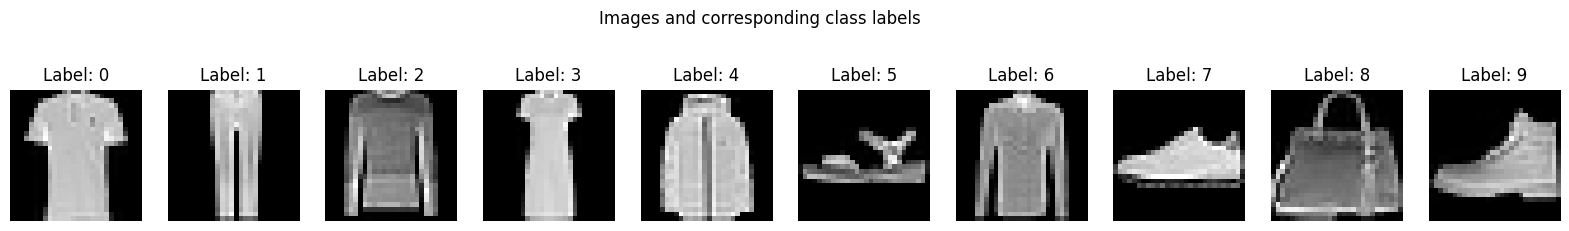

In [31]:
train_images = read_idx3_ubyte("/content/fashion_mnist/train-images-idx3-ubyte")
test_images = read_idx3_ubyte("/content/fashion_mnist/t10k-images-idx3-ubyte")
train_labels = read_idx1_ubyte("/content/fashion_mnist/train-labels-idx1-ubyte")
test_labels = read_idx1_ubyte("/content/fashion_mnist/t10k-labels-idx1-ubyte")

# Taking the first 50k images as train set and rest 10k images as val set
train_images, val_images = train_images[:50000], train_images[50000:60000]
train_labels, val_labels = train_labels[:50000], train_labels[50000:60000]

# Converting all the images to the range of [0, 1]
train_images, test_images, val_images = train_images / 255.0, test_images / 255.0, val_images / 255.0
print("Train, test and val data normalised.")

images_to_be_visualised = list()
labels_to_be_visualised = list()
for image, label in zip(val_images, val_labels):
    if label not in labels_to_be_visualised:
        labels_to_be_visualised.append(label)
        images_to_be_visualised.append(image)

sorted_indices = np.argsort(np.array(labels_to_be_visualised))
labels_to_be_visualised = np.array(labels_to_be_visualised)[sorted_indices]
images_to_be_visualised = np.array(images_to_be_visualised)[sorted_indices]

fig, ax = plt.subplots(1, len(labels_to_be_visualised), figsize=(20, 3))
for i in range(len(labels_to_be_visualised)):
    ax[i].imshow(images_to_be_visualised[i], cmap="gray")
    ax[i].axis("off")
    ax[i].set_title(f"Label: {labels_to_be_visualised[i]}")
fig.suptitle("Images and corresponding class labels")
plt.show()
plt.close()

## Guessing the clothing type

In [15]:
clothing_type = {
    0: "Tshirt",
    1: "Trouser",
    2: "Sweater",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneakers",
    8: "Bag",
    9: "Boots"
}

## Function for plotting original and reconstructed images

In [16]:
def plot_org_vs_recon_imgs(model, test_images, test_labels, path=None):
    reconstructed_images = model.get_reconstructed_images(test_images, test_labels)
    print("Original Images:")
    fig, ax = plt.subplots(1, 10, figsize=(20, 5))
    for i in range(10):
        ax[i].imshow(test_images[i], cmap="gray")
        ax[i].axis("off")
    plt.show()
    plt.close()

    print("Reconstructed Images:")
    fig, ax = plt.subplots(1, 10, figsize=(20, 5))
    for i in range(10):
        ax[i].imshow(reconstructed_images[i], cmap="gray")
        ax[i].axis("off")
    if path is None:
        plt.show()
    else:
        plt.savefig(path)
    plt.close()

## Function to plot graph

In [17]:
def plot_loss_graph(train_loss_arr, val_loss_arr, path=None):
    # Plot the train loss and validation loss graph and save it to drive
    plt.figure(figsize=(20, 6))
    plt.plot(train_loss_arr, label='Training Loss', color='blue', marker='o')
    plt.plot(val_loss_arr, label='Validation Loss', color='orange', marker='o')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')

    plt.legend()
    if path is None:
        plt.show()
    else:
        plt.savefig(path)
    plt.close()

## Function for visualising latent space

In [18]:
def visualise_latent_space(model, plotting_images, plotting_labels, path=None):
    # Getting the encoded representation for each image in train set
    encoded_reps = model.get_encoded_representation(plotting_images, plotting_labels)

    # Flattening the features
    flattened_reps = list()
    for rep in encoded_reps:
        flattened_reps.append(np.squeeze(rep))
    flattened_reps = np.array(flattened_reps)

    # Reducing it to 3 principal components, will use the first 2 for 2D PCA and all 3 for 3D PCA
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(flattened_reps)

    # Plot 2D PCA
    if plotting_labels is not None:
        scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=plotting_labels, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter)
    else:
        plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
    plt.title('2D PCA of Encoded Representations')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.tight_layout()
    if path is None:
        plt.show()
    else:
        plt.savefig(f"{path}_2D_pca.png")
    plt.close()

    # Plot 3D PCA
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if plotting_labels is not None:
        scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=plotting_labels, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter)
    else:
        ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], alpha=0.7)
    ax.set_title('3D PCA of Encoded Representations')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')

    plt.tight_layout()

    # Creating and saving gif
    def update(frame):
        ax.view_init(elev=30, azim=frame)
        return ax,
    frames = np.arange(0, 360, 2)
    ani = FuncAnimation(fig, update, frames=frames, interval=50)
    if path is None:
        HTML(ani.to_jshtml())
    else:
        ani.save(f'{path}_3D_pca.gif', writer='pillow')
    plt.close()
    print("2D and 3D PCA outputs saved")

## Selecting devices and epochs

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 20

print("Device:", device)

Device: cuda


# Hyperparameter Tuning

## Training CNN Autoencoder 1

In [35]:
model1 = CNN_Autoencoder(model_num=1, act_func="relu", lr=0.1, dropout=0.3, optimiser="adam").to(device)
start_time = time.time()
train_loss_arr, val_loss_arr = model1.train_model(train_images, train_images, val_images, val_images, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)

Epoch 1/20 done, Train Loss: 0.1704899746774483
Epoch 2/20 done, Train Loss: 0.17046596911650624
Epoch 3/20 done, Train Loss: 0.17046328267453195
Epoch 4/20 done, Train Loss: 0.17046266740816035
Epoch 5/20 done, Train Loss: 0.17046922587349259
Epoch 6/20 done, Train Loss: 0.17046961676441394
Epoch 7/20 done, Train Loss: 0.17046933502473666
Epoch 8/20 done, Train Loss: 0.17046898661594856
Epoch 9/20 done, Train Loss: 0.170469376048215
Epoch 10/20 done, Train Loss: 0.17046910693114642
Epoch 11/20 done, Train Loss: 0.17046866983995176
Epoch 12/20 done, Train Loss: 0.17046827131254277
Epoch 13/20 done, Train Loss: 0.17046666360786156
Epoch 14/20 done, Train Loss: 0.17047033163880357
Epoch 15/20 done, Train Loss: 0.17046732229066824
Epoch 16/20 done, Train Loss: 0.17046231285967434
Epoch 17/20 done, Train Loss: 0.17046785311712642
Epoch 18/20 done, Train Loss: 0.17046682169554864
Epoch 19/20 done, Train Loss: 0.17046576896616839
Epoch 20/20 done, Train Loss: 0.17047037595140577

Training Co

## Plotting and visualising model 1 output

Original Images:


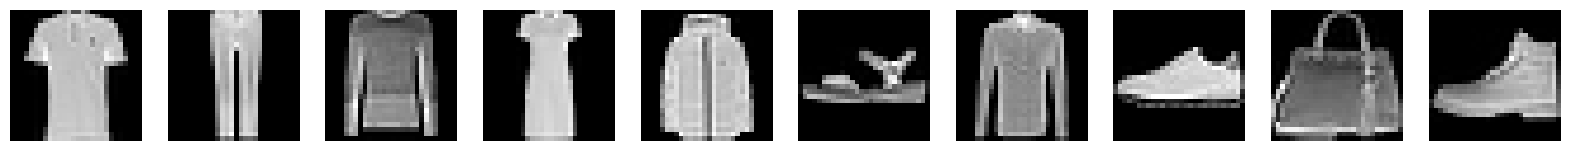

Reconstructed Images:


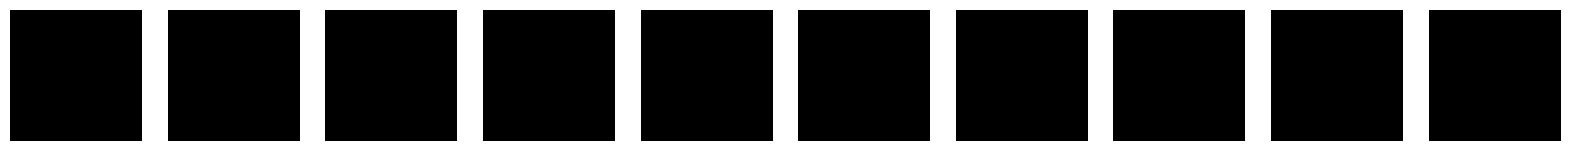


Loss graph:


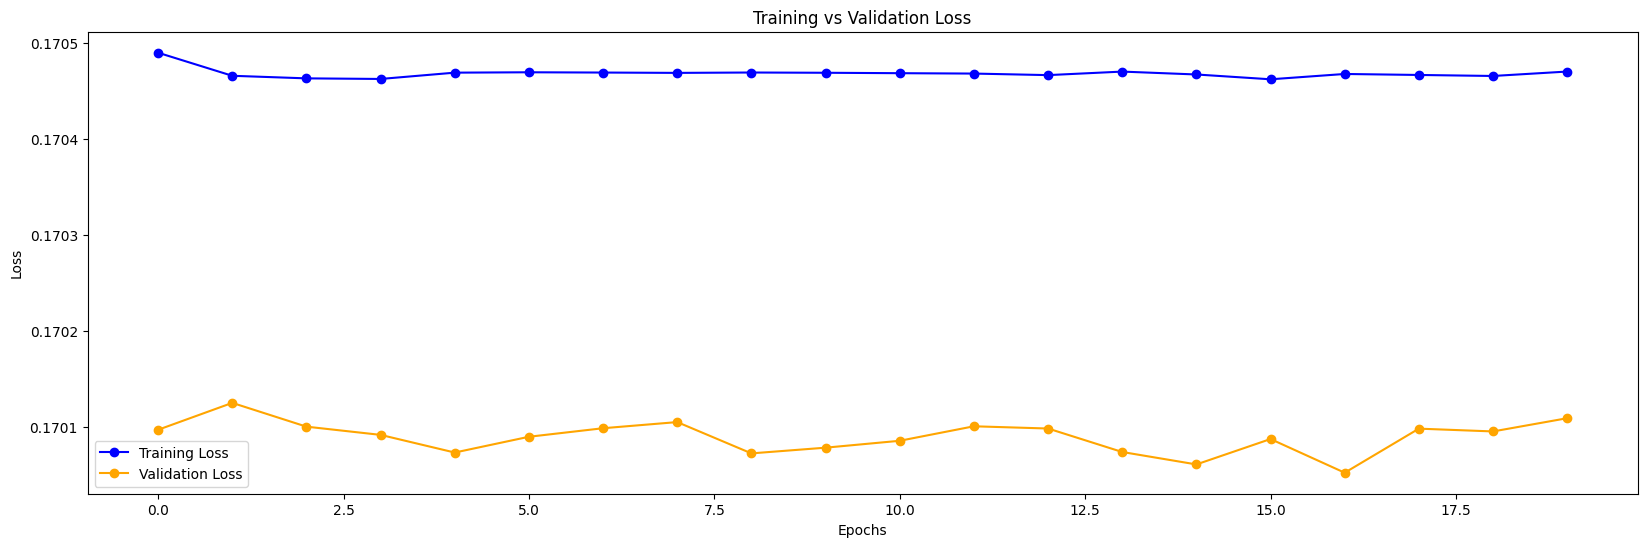


2D and 3D PCA outputs saved


In [36]:
# Plotting original vs reconstructed images
plot_org_vs_recon_imgs(model1, images_to_be_visualised, labels_to_be_visualised, path=None)
print()

# Plotting train loss and val loss vs epochs graph
print("Loss graph:")
plot_loss_graph(train_loss_arr, val_loss_arr, path=None)
print()

# Visualising latent space
plotting_images = test_images[:1000]
plotting_labels = test_labels[:1000]
visualise_latent_space(model1, plotting_images, plotting_labels, path="/content/drive/MyDrive/smai_a4/figures/cnn_autoencoder/model1")

## Training CNN Autoencoder 2

In [37]:
model2 = CNN_Autoencoder(model_num=2, act_func="relu", lr=1, dropout=0.3, optimiser="sgd").to(device)
start_time = time.time()
train_loss_arr, val_loss_arr = model2.train_model(train_images, train_images, val_images, val_images, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)

Epoch 1/20 done, Train Loss: 0.16505710809221652
Epoch 2/20 done, Train Loss: 0.15603969715683413
Epoch 3/20 done, Train Loss: 0.15013410016579729
Epoch 4/20 done, Train Loss: 0.14911046503105763
Epoch 5/20 done, Train Loss: 0.14857895806269697
Epoch 6/20 done, Train Loss: 0.14826286699973232
Epoch 7/20 done, Train Loss: 0.14803860014780013
Epoch 8/20 done, Train Loss: 0.14785063661449016
Epoch 9/20 done, Train Loss: 0.14765411826066305
Epoch 10/20 done, Train Loss: 0.1473665837954041
Epoch 11/20 done, Train Loss: 0.14719921636013214
Epoch 12/20 done, Train Loss: 0.1470923526683299
Epoch 13/20 done, Train Loss: 0.146959262298836
Epoch 14/20 done, Train Loss: 0.14681339079439068
Epoch 15/20 done, Train Loss: 0.1467101158179767
Epoch 16/20 done, Train Loss: 0.1466303671104208
Epoch 17/20 done, Train Loss: 0.14657185586575736
Epoch 18/20 done, Train Loss: 0.14651246324076686
Epoch 19/20 done, Train Loss: 0.1464552341537909
Epoch 20/20 done, Train Loss: 0.14639842223259247

Training Comple

## Plotting and visualising model 2 output

Original Images:


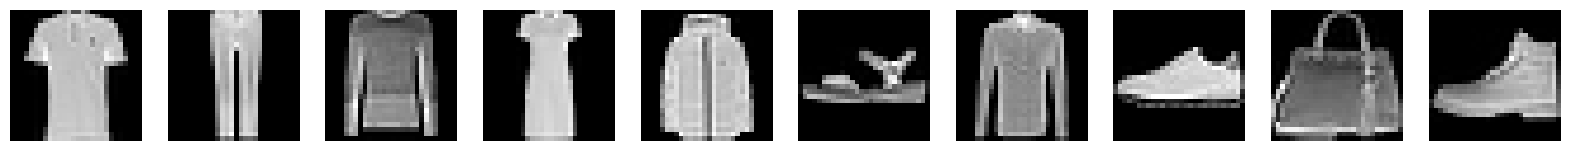

Reconstructed Images:


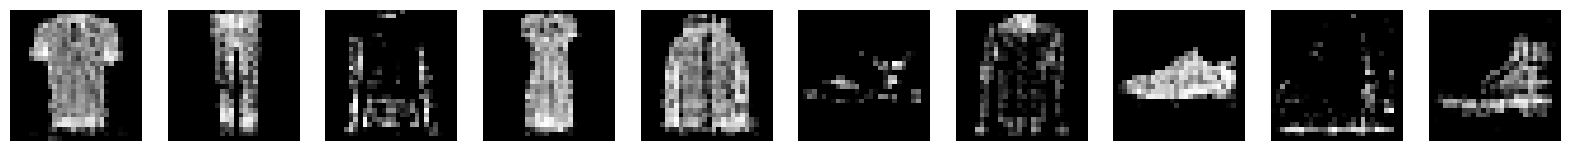


Loss graph:


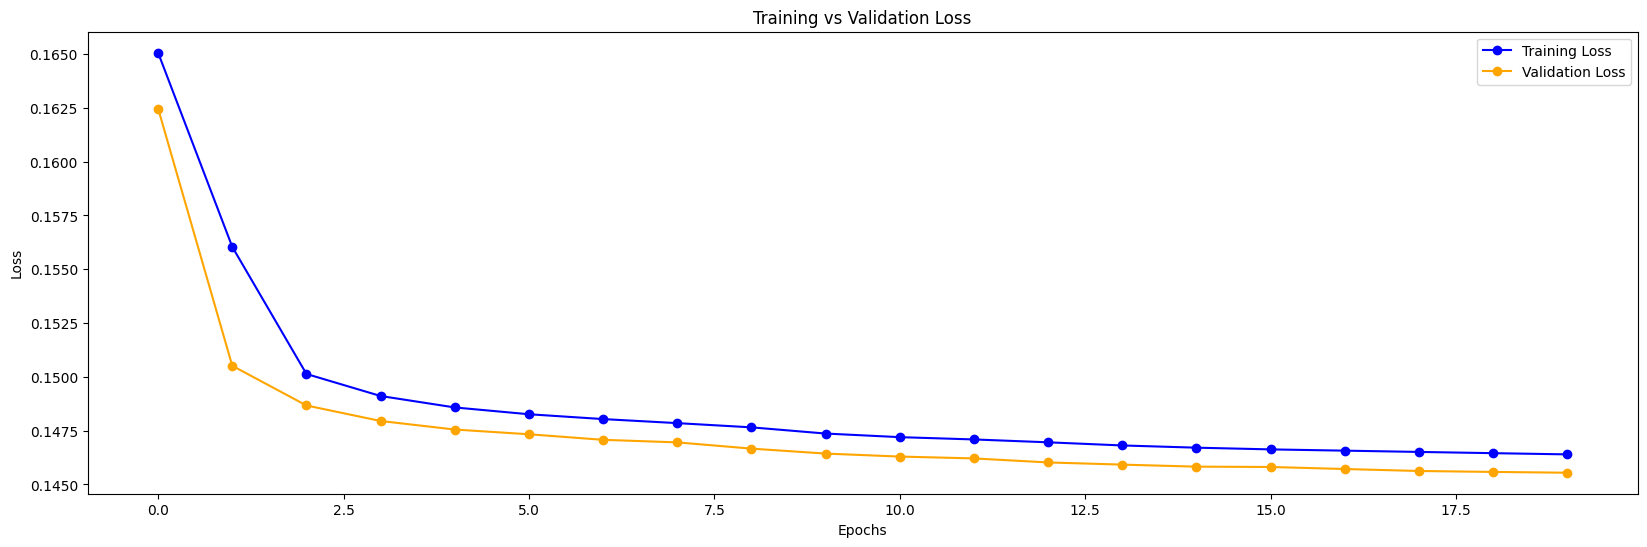


2D and 3D PCA outputs saved


In [38]:
# Plotting original vs reconstructed images
plot_org_vs_recon_imgs(model2, images_to_be_visualised, labels_to_be_visualised, path=None)
print()

# Plotting train loss and val loss vs epochs graph
print("Loss graph:")
plot_loss_graph(train_loss_arr, val_loss_arr, path=None)
print()

# Visualising latent space
plotting_images = test_images[:1000]
plotting_labels = test_labels[:1000]
visualise_latent_space(model2, plotting_images, plotting_labels, path="/content/drive/MyDrive/smai_a4/figures/cnn_autoencoder/model2")

## Training CNN Autoencoder 3

In [39]:
model3 = CNN_Autoencoder(model_num=3, act_func="relu", lr=1, dropout=0.3, optimiser="sgd").to(device)
start_time = time.time()
train_loss_arr, val_loss_arr = model3.train_model(train_images, train_images, val_images, val_images, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)

Epoch 1/20 done, Train Loss: 0.1701817751426538
Epoch 2/20 done, Train Loss: 0.16326129405031736
Epoch 3/20 done, Train Loss: 0.15050500445425397
Epoch 4/20 done, Train Loss: 0.14849662444222378
Epoch 5/20 done, Train Loss: 0.14783685669179003
Epoch 6/20 done, Train Loss: 0.1474720031995462
Epoch 7/20 done, Train Loss: 0.14724230158046814
Epoch 8/20 done, Train Loss: 0.14707949373368187
Epoch 9/20 done, Train Loss: 0.1469461474083817
Epoch 10/20 done, Train Loss: 0.14684332377126563
Epoch 11/20 done, Train Loss: 0.14675008014120966
Epoch 12/20 done, Train Loss: 0.14667417412184022
Epoch 13/20 done, Train Loss: 0.1466050706732296
Epoch 14/20 done, Train Loss: 0.14653266713223392
Epoch 15/20 done, Train Loss: 0.14647570291506656
Epoch 16/20 done, Train Loss: 0.14641190533331397
Epoch 17/20 done, Train Loss: 0.14634749940665046
Epoch 18/20 done, Train Loss: 0.14629088680159183
Epoch 19/20 done, Train Loss: 0.14622618158849018
Epoch 20/20 done, Train Loss: 0.14617925044804603

Training Com

## Plotting and visualising model 3 output

Original Images:


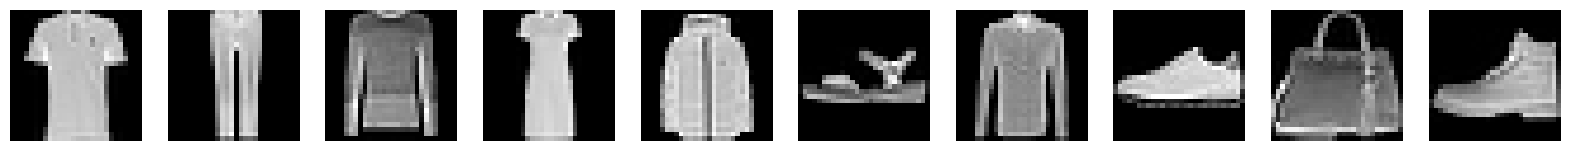

Reconstructed Images:


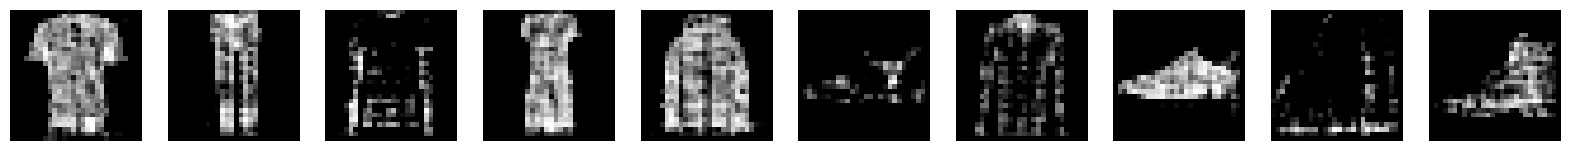


Loss graph:


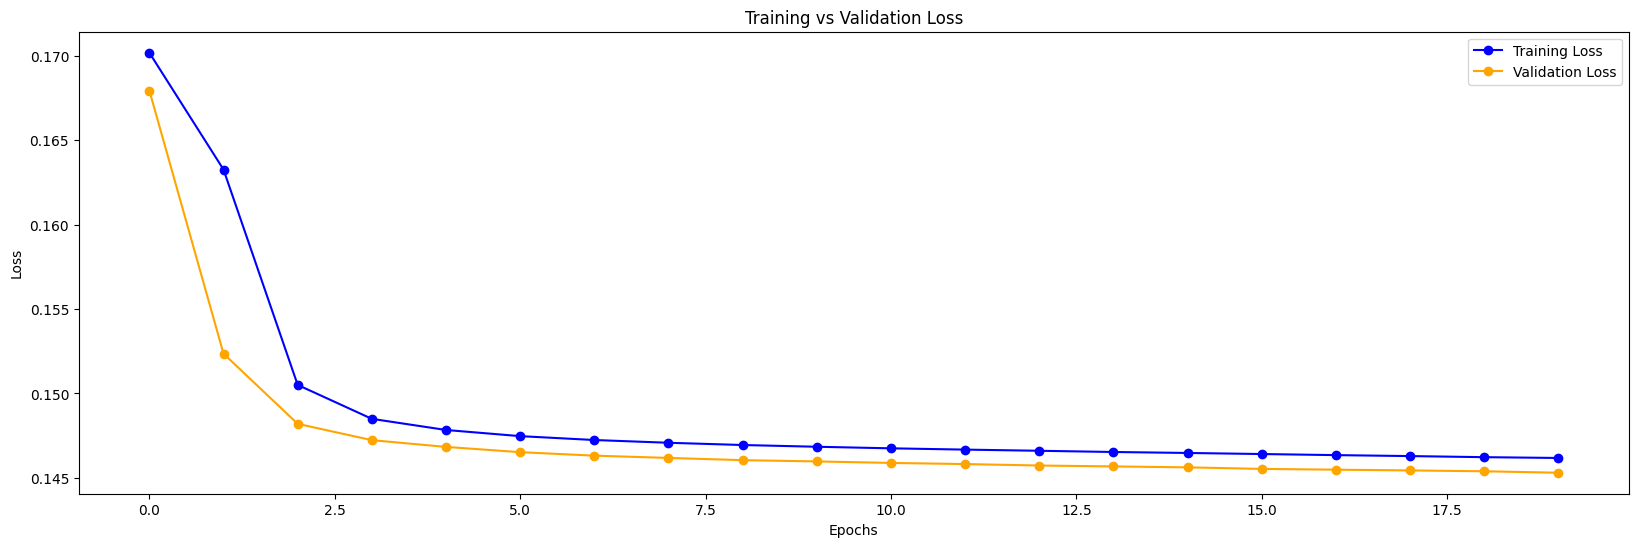


2D and 3D PCA outputs saved


In [40]:
# Plotting original vs reconstructed images
plot_org_vs_recon_imgs(model3, images_to_be_visualised, labels_to_be_visualised, path=None)
print()

# Plotting train loss and val loss vs epochs graph
print("Loss graph:")
plot_loss_graph(train_loss_arr, val_loss_arr, path=None)
print()

# Visualising latent space
plotting_images = test_images[:1000]
plotting_labels = test_labels[:1000]
visualise_latent_space(model3, plotting_images, plotting_labels, path="/content/drive/MyDrive/smai_a4/figures/cnn_autoencoder/model3")

## Best performing model

In [ ]:
best_model = 2

> There is not much difference in model 2 and 3 but 3 has more parameters (number of neurons per layer) so we will take model 2 as our best model. And we can also clearly see that the difference has been caused by the change in learning rate and optimiser.

# Analysing Effect of depth on model

## Training CNN Autoencoder 4

In [41]:
model4 = CNN_Autoencoder(model_num=4, act_func="relu", lr=1, dropout=0.3, optimiser="sgd").to(device)
start_time = time.time()
train_loss_arr, val_loss_arr = model4.train_model(train_images, train_images, val_images, val_images, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)

Epoch 1/20 done, Train Loss: 0.1704661146197194
Epoch 2/20 done, Train Loss: 0.15510347338723435
Epoch 3/20 done, Train Loss: 0.1452787161035486
Epoch 4/20 done, Train Loss: 0.14440976782098308
Epoch 5/20 done, Train Loss: 0.14410131696852368
Epoch 6/20 done, Train Loss: 0.1439222059357418
Epoch 7/20 done, Train Loss: 0.1437714509022442
Epoch 8/20 done, Train Loss: 0.1436797169133096
Epoch 9/20 done, Train Loss: 0.1436044736476335
Epoch 10/20 done, Train Loss: 0.14353931189937158
Epoch 11/20 done, Train Loss: 0.1434795426839983
Epoch 12/20 done, Train Loss: 0.14344227555674463
Epoch 13/20 done, Train Loss: 0.1433991347931168
Epoch 14/20 done, Train Loss: 0.14337106066698152
Epoch 15/20 done, Train Loss: 0.1433274288991286
Epoch 16/20 done, Train Loss: 0.14331047986267625
Epoch 17/20 done, Train Loss: 0.14328567550225055
Epoch 18/20 done, Train Loss: 0.14326382487516562
Epoch 19/20 done, Train Loss: 0.1432452479988737
Epoch 20/20 done, Train Loss: 0.1432297908422738

Training Complete, 

## Plotting and visualising model 4 output

Original Images:


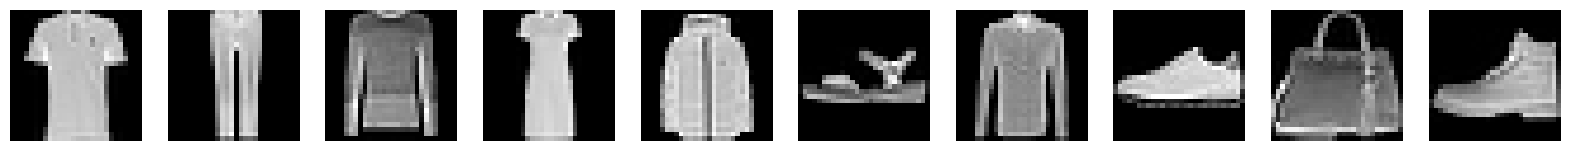

Reconstructed Images:


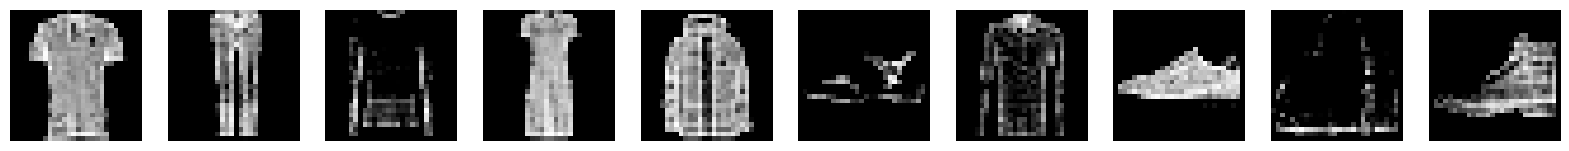


Loss graph:


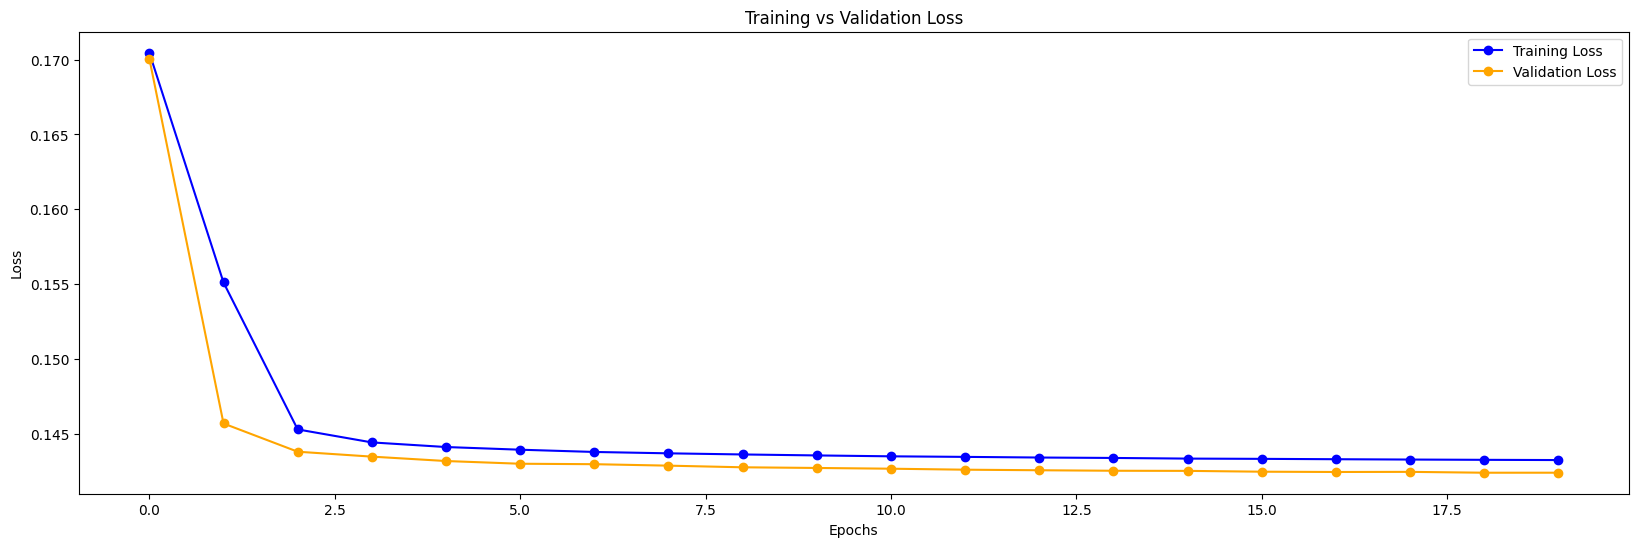


2D and 3D PCA outputs saved


In [42]:
# Plotting original vs reconstructed images
plot_org_vs_recon_imgs(model4, images_to_be_visualised, labels_to_be_visualised, path=None)
print()

# Plotting train loss and val loss vs epochs graph
print("Loss graph:")
plot_loss_graph(train_loss_arr, val_loss_arr, path=None)
print()

# Visualising latent space
plotting_images = test_images[:1000]
plotting_labels = test_labels[:1000]
visualise_latent_space(model4, plotting_images, plotting_labels, path="/content/drive/MyDrive/smai_a4/figures/cnn_autoencoder/model4")

## Training CNN Autoencoder 5

In [47]:
model5 = CNN_Autoencoder(model_num=5, act_func="tanh", lr=10, dropout=0.3, optimiser="sgd").to(device)
start_time = time.time()
train_loss_arr, val_loss_arr = model5.train_model(train_images, train_images, val_images, val_images, epochs=20)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)

Epoch 1/20 done, Train Loss: 0.124820481859486
Epoch 2/20 done, Train Loss: 0.124741232931919
Epoch 3/20 done, Train Loss: 0.12473505886029679
Epoch 4/20 done, Train Loss: 0.12473240231598179
Epoch 5/20 done, Train Loss: 0.12472727351839238
Epoch 6/20 done, Train Loss: 0.12472694259916295
Epoch 7/20 done, Train Loss: 0.12473180745647873
Epoch 8/20 done, Train Loss: 0.12472942136871609
Epoch 9/20 done, Train Loss: 0.1247288901895113
Epoch 10/20 done, Train Loss: 0.12473364097143089
Epoch 11/20 done, Train Loss: 0.12472801513478914
Epoch 12/20 done, Train Loss: 0.12473897445739573
Epoch 13/20 done, Train Loss: 0.12473555568484107
Epoch 14/20 done, Train Loss: 0.12473266808672433
Epoch 15/20 done, Train Loss: 0.12473304254156004
Epoch 16/20 done, Train Loss: 0.12473388460493973
Epoch 17/20 done, Train Loss: 0.12472767719399525
Epoch 18/20 done, Train Loss: 0.12472905257689365
Epoch 19/20 done, Train Loss: 0.124728469667874
Epoch 20/20 done, Train Loss: 0.12473224621130272

Training Comple

## Plotting and visualising model 5 output

Original Images:


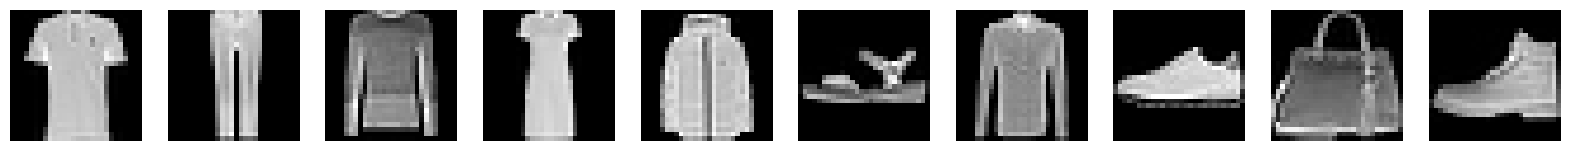

Reconstructed Images:


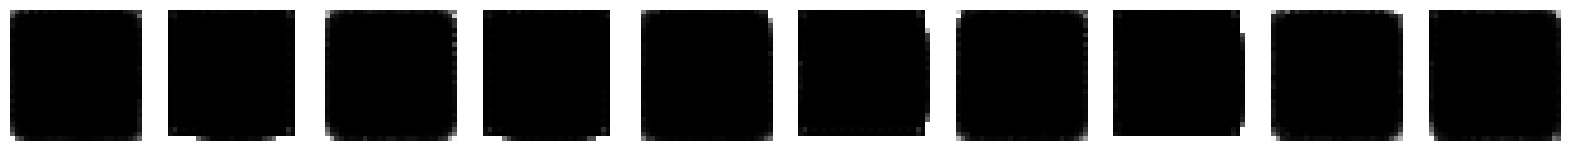


Loss graph:


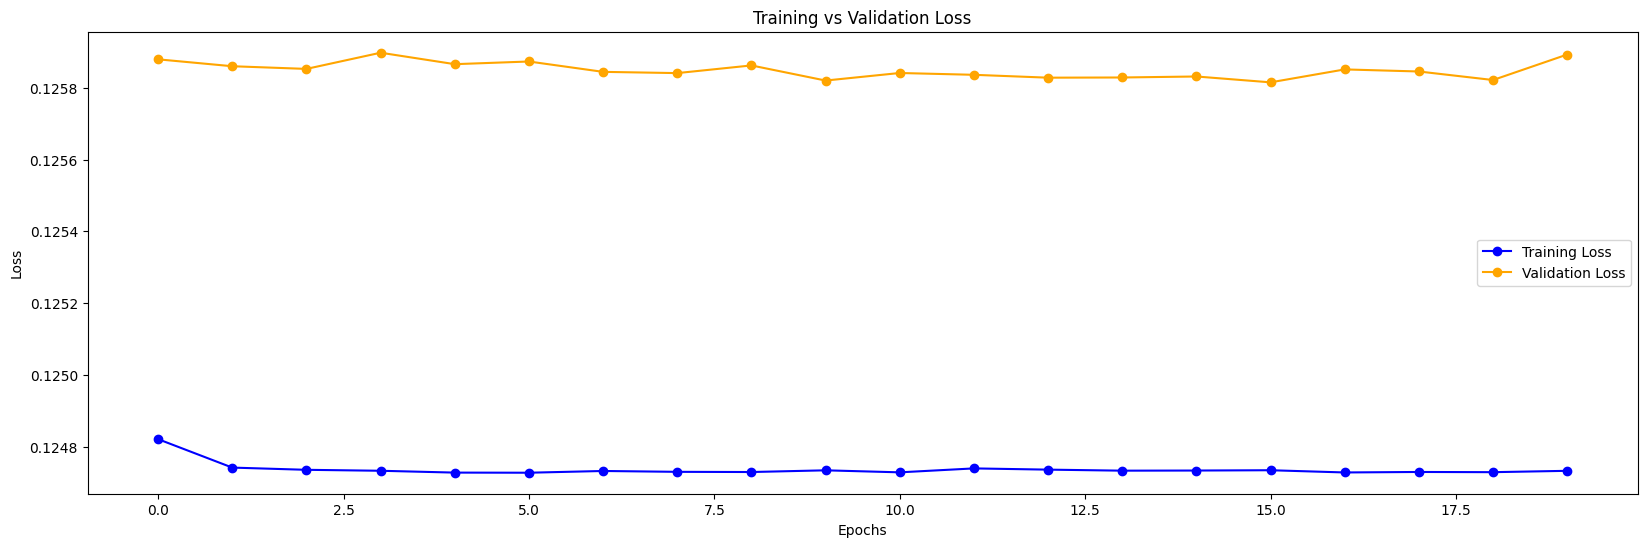


2D and 3D PCA outputs saved


In [48]:
# Plotting original vs reconstructed images
plot_org_vs_recon_imgs(model5, images_to_be_visualised, labels_to_be_visualised, path=None)
print()

# Plotting train loss and val loss vs epochs graph
print("Loss graph:")
plot_loss_graph(train_loss_arr, val_loss_arr, path=None)
print()

# Visualising latent space
plotting_images = test_images[:1000]
plotting_labels = test_labels[:1000]
visualise_latent_space(model5, plotting_images, plotting_labels, path="/content/drive/MyDrive/smai_a4/figures/cnn_autoencoder/model5")

## Training CNN Autoencoder 6

In [45]:
model6 = CNN_Autoencoder(model_num=6, act_func="tanh", lr=1, dropout=0.3, optimiser="sgd").to(device)
start_time = time.time()
train_loss_arr, val_loss_arr = model6.train_model(train_images, train_images, val_images, val_images, epochs=20)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)

Epoch 1/20 done, Train Loss: 0.0553677747322822
Epoch 2/20 done, Train Loss: 0.048597900927429084
Epoch 3/20 done, Train Loss: 0.04780809097206524
Epoch 4/20 done, Train Loss: 0.04737358625384759
Epoch 5/20 done, Train Loss: 0.047073509856362564
Epoch 6/20 done, Train Loss: 0.04687017571807899
Epoch 7/20 done, Train Loss: 0.04670710602128117
Epoch 8/20 done, Train Loss: 0.04657559313704704
Epoch 9/20 done, Train Loss: 0.04645091339812321
Epoch 10/20 done, Train Loss: 0.04634647746823647
Epoch 11/20 done, Train Loss: 0.0462582227193005
Epoch 12/20 done, Train Loss: 0.04619343586442414
Epoch 13/20 done, Train Loss: 0.046130035246554964
Epoch 14/20 done, Train Loss: 0.046078715011029385
Epoch 15/20 done, Train Loss: 0.046032880204691005
Epoch 16/20 done, Train Loss: 0.045991902421356694
Epoch 17/20 done, Train Loss: 0.0459607395671799
Epoch 18/20 done, Train Loss: 0.04592896459513342
Epoch 19/20 done, Train Loss: 0.045893658162288305
Epoch 20/20 done, Train Loss: 0.045864569586931095

Tra

## Plotting and visualising model 6 output

Original Images:


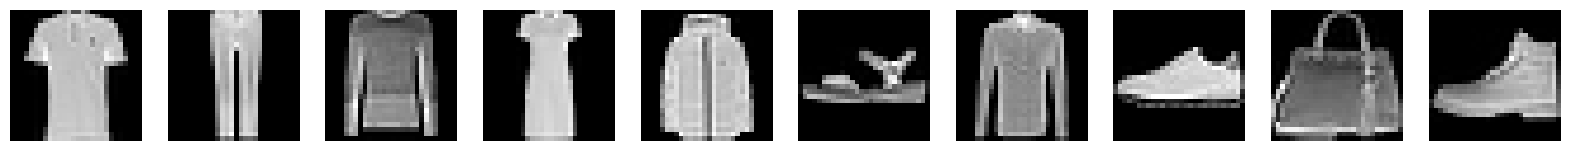

Reconstructed Images:


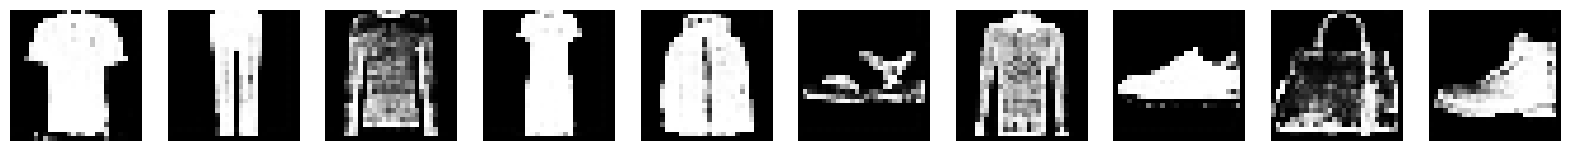


Loss graph:


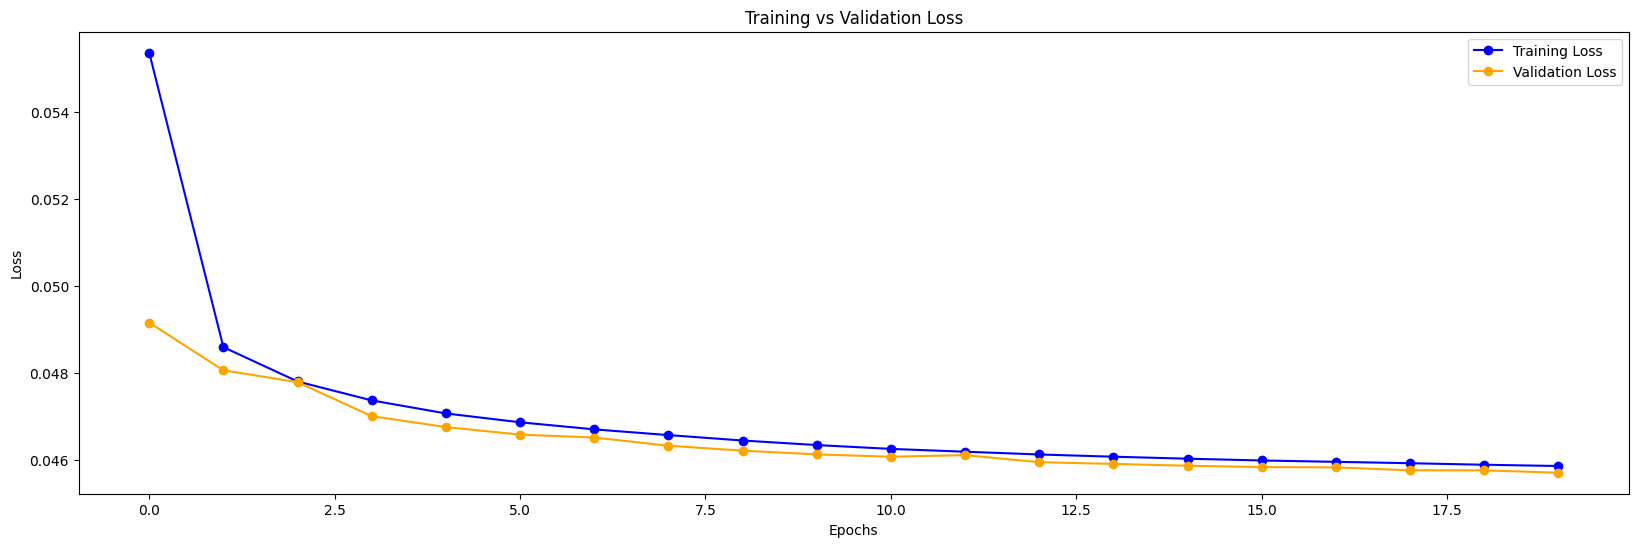


2D and 3D PCA outputs saved


In [46]:
# Plotting original vs reconstructed images
plot_org_vs_recon_imgs(model6, images_to_be_visualised, labels_to_be_visualised, path=None)
print()

# Plotting train loss and val loss vs epochs graph
print("Loss graph:")
plot_loss_graph(train_loss_arr, val_loss_arr, path=None)
print()

# Visualising latent space
plotting_images = test_images[:1000]
plotting_labels = test_labels[:1000]
visualise_latent_space(model6, plotting_images, plotting_labels, path="/content/drive/MyDrive/smai_a4/figures/cnn_autoencoder/model6")

> Here we can see that model 4 (2 layers) performs better than model 5 (3 layers), and model 6 (4 layers) perform better than either of the previous 2, which somewhat implies that even number of layers are somehow more helpful in training for this particular task (given a constant number of latent space dimensions). Also tanh activation function works better than ReLU in this task. Also I tried out different learning rates but for this task it requires a higher learning rate to learn, this may be due to the fact that the model might be getting stuck in local minima or else the loss function must be flat at most of the places.